In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [7]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation_fr(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def binned_participation_mat(unit_mat_binary,bin_width=50):
    bins = np.arange(0,unit_mat_binary.shape[1],bin_width)

    unit_mat_binary_sum = []
    for i in range(len(bins)-1):
        unit_mat_binary_sum.append(unit_mat_binary[:,bins[i]:bins[i+1]].sum(axis=1))

    return np.vstack(unit_mat_binary_sum).T

def participation_regression(binned_unit_mat):
    X = np.arange(0,binned_unit_mat.shape[1])
    r2 = []
    b = []
    intercept = []
    pval = []
    std_err = []
    for y in binned_unit_mat:
        slope, intercept_, r_value, p_value, std_err_ = stats.linregress(X,y)
        b.append(slope)
        intercept.append(intercept_)
        r2.append(r_value)
        pval.append(p_value)
        std_err.append(std_err_)

    b = np.array(b)
    intercept = np.array(intercept)
    r = np.array(r2)
    pval = np.array(pval)
    std_err = np.array(std_err)
    return b,intercept,r,pval,std_err

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # create spike train object with ripple epochs
    st_unit_rip = st_unit[ripple_epochs]

    epochs = ['pre','task','post']

    for i,ep in enumerate(behavioral_epochs):
        temp_save = pd.DataFrame()

        unit_mat = get_participation(st_unit_rip[ep],
                                        ripple_epochs[ep])
        participation_prob = np.sum(unit_mat,axis=1) / unit_mat.shape[1]

        binned_unit_mat = binned_participation_mat(unit_mat)
        b,intercept,r,pval,std_err = participation_regression(binned_unit_mat)

        # package results and previously saved metrics
        temp_save['UID'] = cell_metrics.UID
        temp_save['basepath'] = cell_metrics.basepath
        temp_save['epoch'] = epochs[i]
        temp_save['putativeCellType'] = cell_metrics.putativeCellType
        temp_save['deepSuperficial'] = cell_metrics.deepSuperficial
        temp_save['burstIndex_Mizuseki2012_overall'] = cell_metrics.burstIndex_Mizuseki2012
        temp_save['firingRate_overall'] = cell_metrics.firingRate
        temp_save['ripple_FRall_overall'] = cell_metrics.ripple_FRall
        temp_save['rankorder_overall'] = cell_metrics.rankorder
        temp_save['ripple_particip_overall'] = cell_metrics.ripple_particip
        temp_save['ripples_modulationIndex'] = cell_metrics.ripples_modulationIndex
        temp_save['participation_prob'] = participation_prob
        temp_save['b'] = b
        temp_save['intercept'] = intercept
        temp_save['r'] = r
        temp_save['pval'] = pval
        temp_save['std_err'] = std_err

        df_save = df_save.append(temp_save,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                    data['epochs'].stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs)
    df_save.to_csv(save_file)

def participation_change_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)    

In [8]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\participation_change'

# get grosmark sessions
df = df.loc[df['basepath'].str.contains("grosmark", case=False)]

participation_change_run(df,save_path,parallel=False)

Z:\Data\GrosmarkAD\Achilles\Achilles_10252013


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Achilles\Achilles_11012013


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Buddy\Buddy_06272013


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Cicero\Cicero_09012014


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Cicero\Cicero_09102014


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Cicero\Cicero_09172014


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [9]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

df = load_in_everything(save_path)
df

Unnamed: 0  UID                                       basepath epoch  \
0              0    1  A:\Data\GrosmarkAD\Achilles\Achilles_10252013   pre   
1              1    3  A:\Data\GrosmarkAD\Achilles\Achilles_10252013   pre   
2              2    4  A:\Data\GrosmarkAD\Achilles\Achilles_10252013   pre   
3              3    7  A:\Data\GrosmarkAD\Achilles\Achilles_10252013   pre   
4              4    9  A:\Data\GrosmarkAD\Achilles\Achilles_10252013   pre   
...          ...  ...                                            ...   ...   
1930         118   42      A:\Data\GrosmarkAD\Gatsby\Gatsby_08282013  post   
1931         119   43      A:\Data\GrosmarkAD\Gatsby\Gatsby_08282013  post   
1932         120   44      A:\Data\GrosmarkAD\Gatsby\Gatsby_08282013  post   
1933         121   45      A:\Data\GrosmarkAD\Gatsby\Gatsby_08282013  post   
1934         122   46      A:\Data\GrosmarkAD\Gatsby\Gatsby_08282013  post   

      participation_prob         b  intercept         r          pval  \
0               0.169686  0.076919   4.835911  0.528771  3.061745e-08   
1               0.163023  0.052387   5.657431  0.460045  2.409650e-06   
2               0.039559  0.006186   1.685352  0.128074  2.136641e-01   
3               0.139288 -0.032142   8.495490 -0.338442  7.443285e-04   
4               0.062461 -0.018828   4.019330 -0.249890  1.407165e-02   
...                  ...       ...        ...       ...           ...   
1930            0.237763 -0.030294  13.719146 -0.335328  1.811980e-04   
1931            0.237100 -0.005056  12.150826 -0.059002  5.220904e-01   
1932            0.178198 -0.014803   9.805785 -0.160930  7.910310e-02   
1933            0.185830 -0.024856  10.778926 -0.327147  2.652257e-04   
1934            0.172557 -0.010667   9.234711 -0.129782  1.577179e-01   

       std_err  
0     0.012735  
1     0.010429  
2     0.004940  
3     0.009217  
4     0.007525  
...        ...  
1930  0.007835  
1931  0.007875  
1932  0.008358  
1933  0.006609  
1934  0.007503  

[1935 rows x 10 columns]

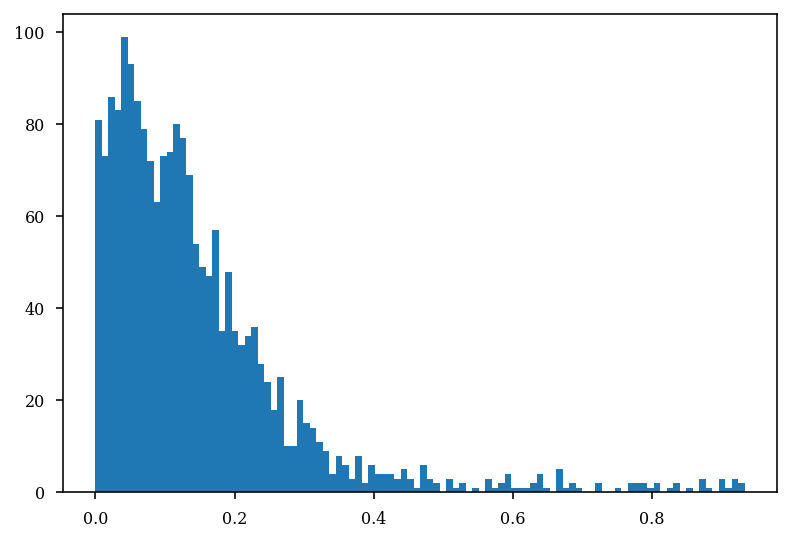

In [11]:
plt.hist(df.participation_prob,100)
plt.show()

In [151]:
basepath = df.basepath.iloc[0]
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

In [152]:
# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object), fs=fs_dat)

# behavioral epochs
behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                    data['epochs'].stopTime]).T])

                                                    
                                                    
restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [153]:
unit_mat = get_participation(st_unit[behavioral_epochs[1]][ripple_epochs],ripple_epochs[behavioral_epochs[1]])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [291]:
unit_mat_pre = get_participation(st_unit[behavioral_epochs[0]][ripple_epochs],ripple_epochs[behavioral_epochs[0]])


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [294]:
unit_mat_pre_binary = (unit_mat_pre > 0)*1
pre_participation_prob = np.sum(unit_mat_pre_binary,axis=1) / unit_mat_pre_binary.shape[1]

(198,)

<AxesSubplot:>

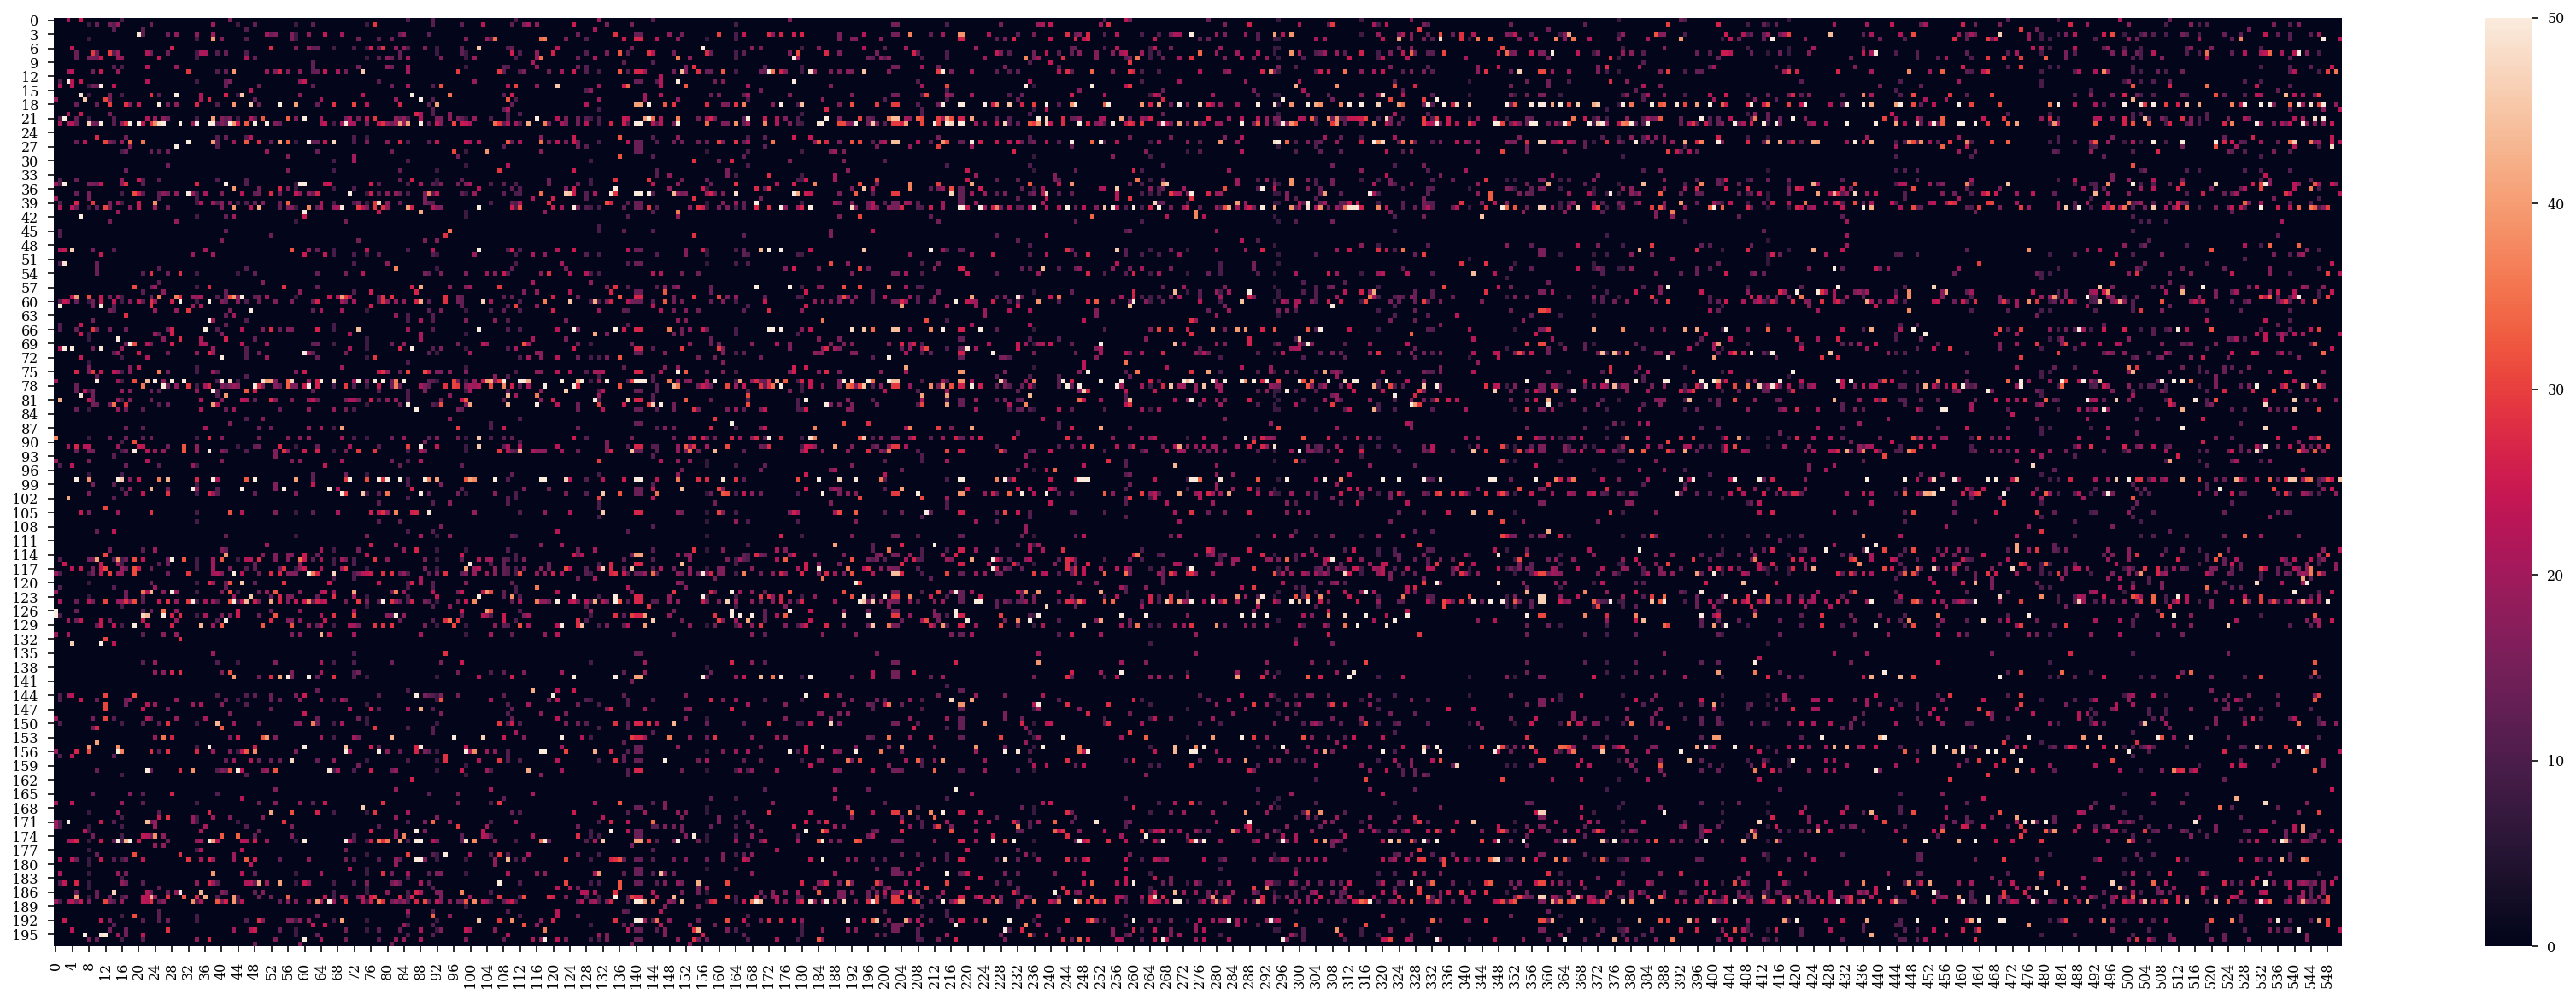

In [8]:
plt.figure(figsize=(30,10))
sns.heatmap(unit_mat,vmax=50)

<AxesSubplot:>

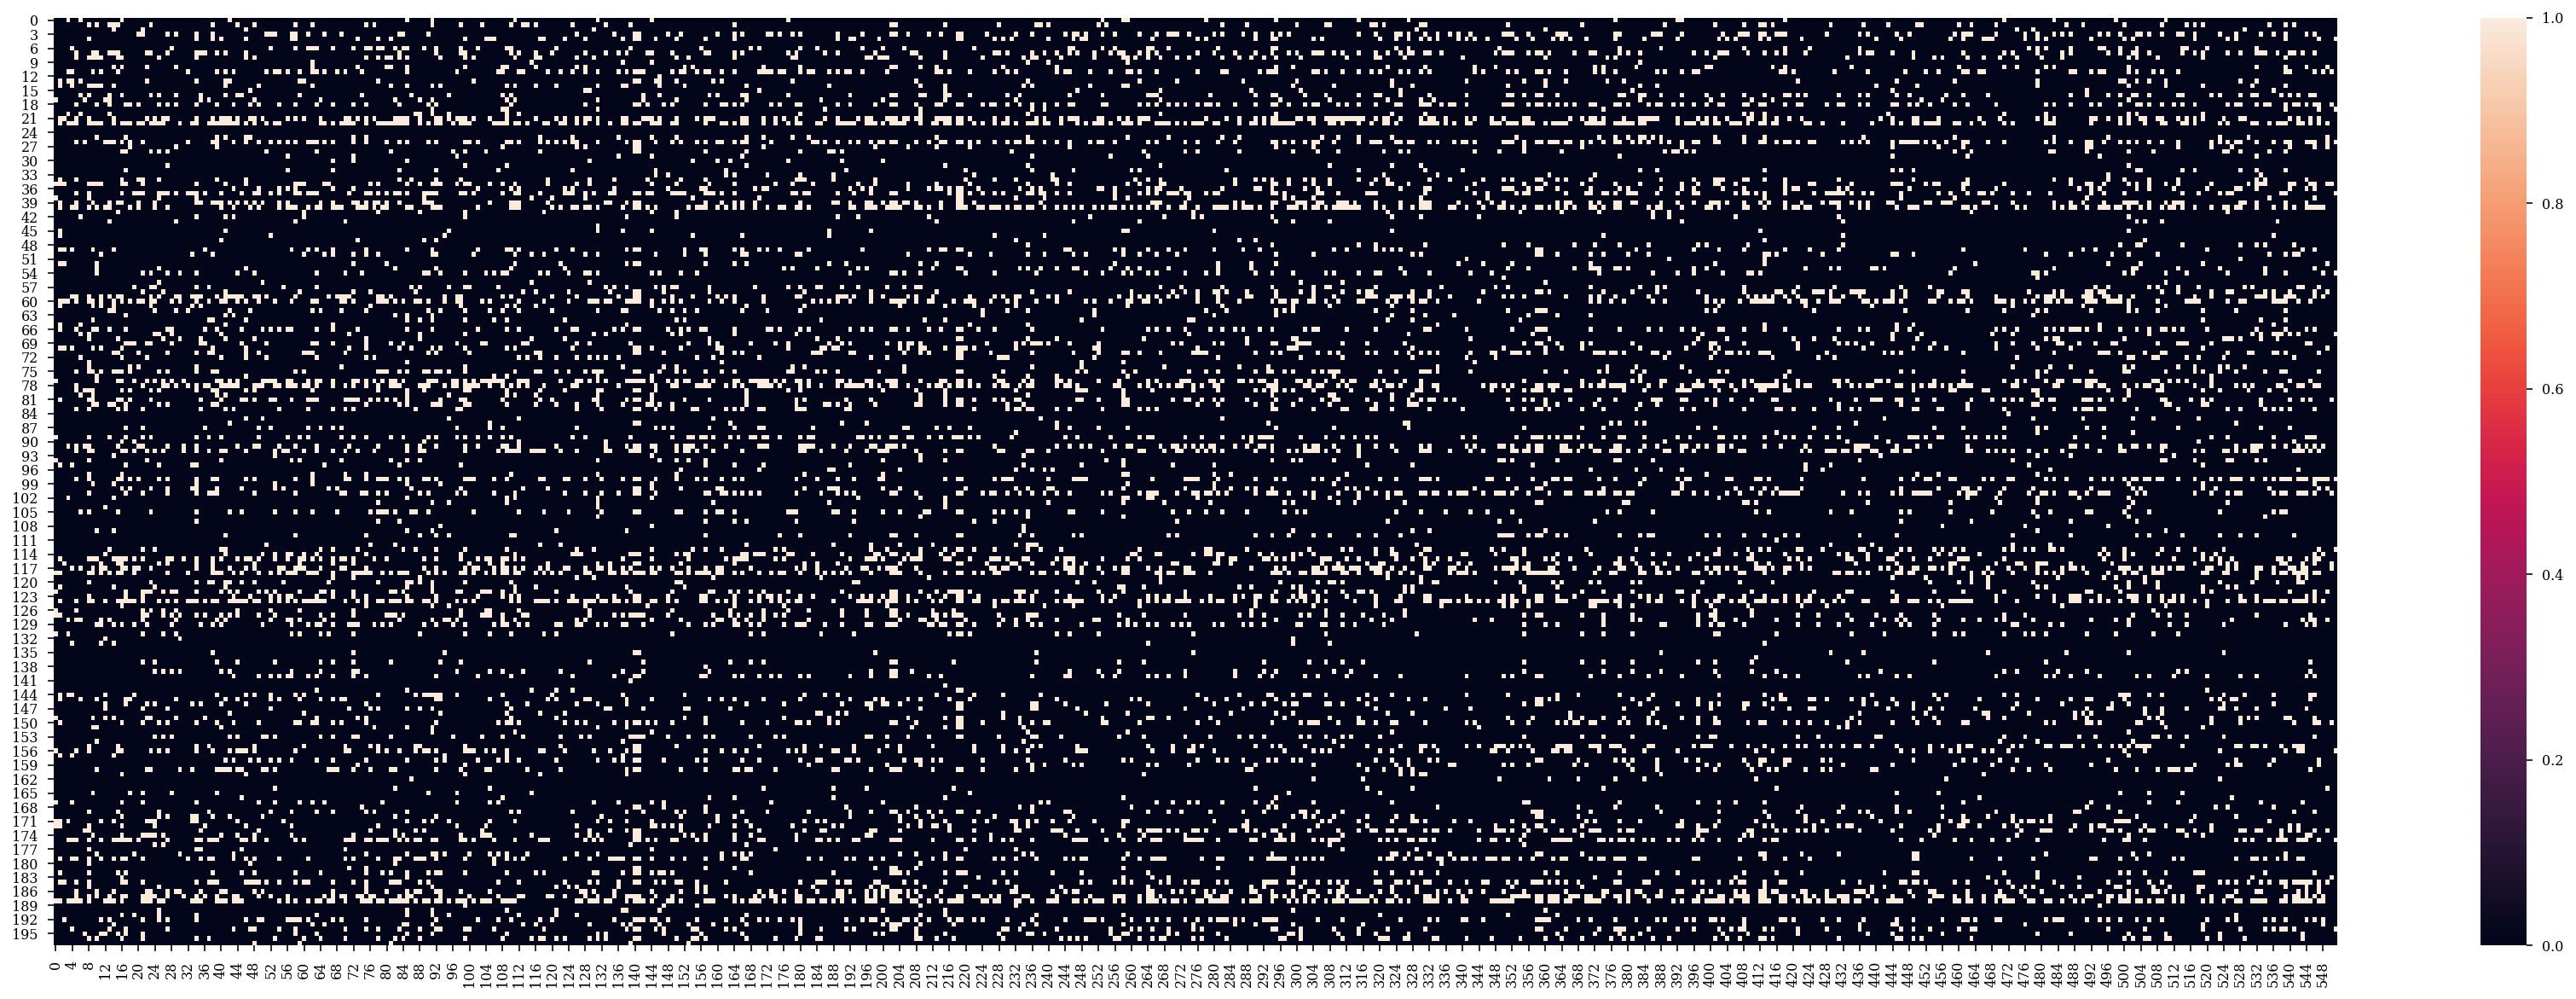

In [191]:
unit_mat_binary = (unit_mat > 0)*1

plt.figure(figsize=(30,10))
sns.heatmap(unit_mat_binary)

In [155]:
participation_prob = np.sum(unit_mat_binary,axis=1) / unit_mat_binary.shape[1]
pop_participation_prob = np.sum(unit_mat_binary,axis=0) / unit_mat_binary.shape[0]

# ripple duration is related to pop ripple firing rate 

Text(0, 0.5, 'mean pop ripple FR')

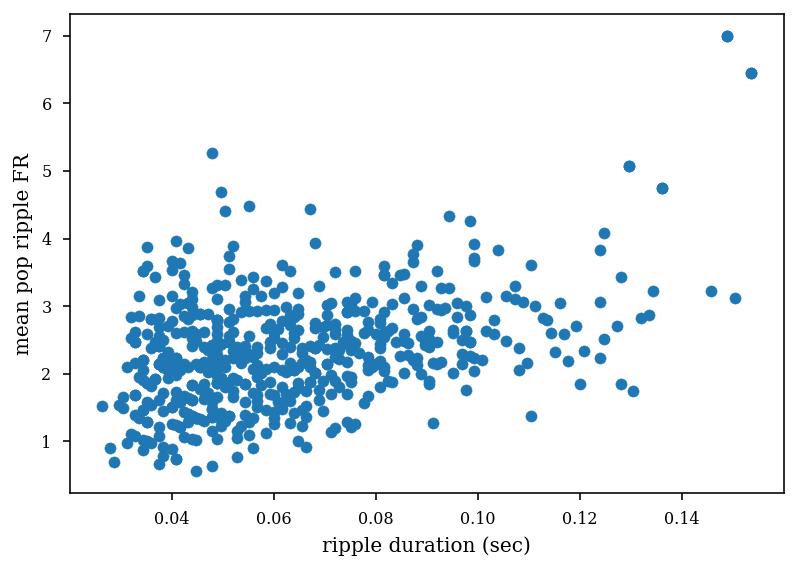

In [17]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths,unit_mat.mean(axis=0))
plt.xlabel('ripple duration (sec)')
plt.ylabel('mean pop ripple FR')


# ripple duration largely predicts population participation

Text(0, 0.5, 'pop participation prob.')

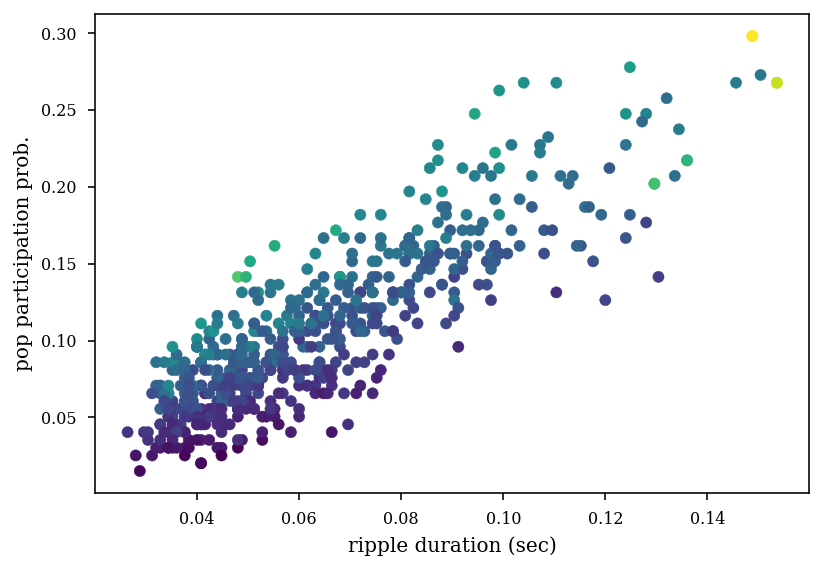

In [20]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths,pop_participation_prob,c=unit_mat.mean(axis=0))
plt.xlabel('ripple duration (sec)')
plt.ylabel('pop participation prob.')

# ripple duration is not related to ripple to ripple lag time

Text(0, 0.5, 'ripple to ripple lag (sec)')

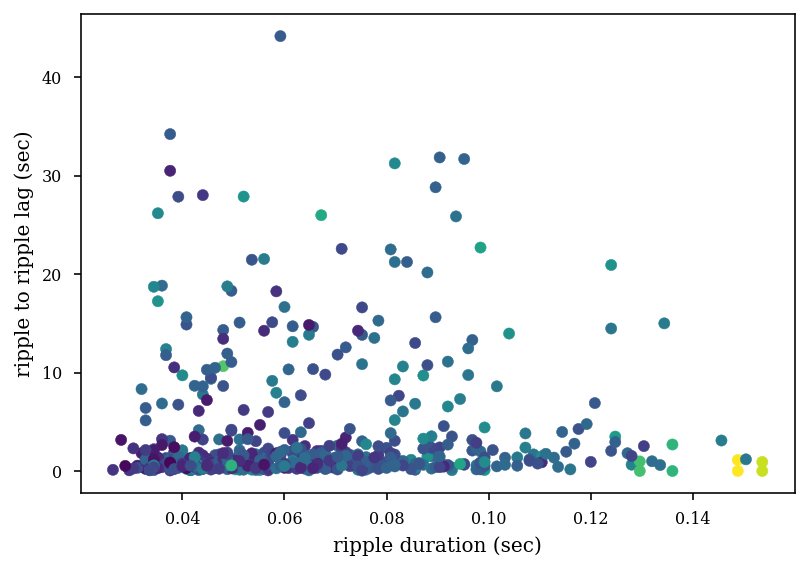

In [35]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths[1:], np.diff(ripple_epochs[behavioral_epochs[1]].starts),c=unit_mat.mean(axis=0)[1:])
# plt.yscale("log")

plt.xlabel('ripple duration (sec)')
plt.ylabel('ripple to ripple lag (sec)')

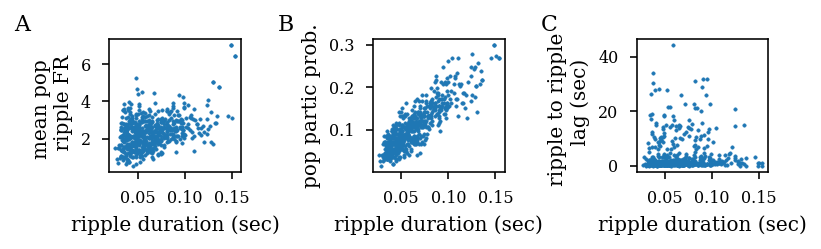

In [173]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=1)
axs = axs.ravel()

axs[0].scatter(ripple_epochs[behavioral_epochs[1]].lengths,unit_mat.mean(axis=0),s=3)
axs[0].set_xlabel('ripple duration (sec)')
axs[0].set_ylabel('mean pop \n ripple FR')

axs[1].scatter(ripple_epochs[behavioral_epochs[1]].lengths,pop_participation_prob,s=3)
axs[1].set_xlabel('ripple duration (sec)')
axs[1].set_ylabel('pop partic prob.')

axs[2].scatter(ripple_epochs[behavioral_epochs[1]].lengths[1:], np.diff(ripple_epochs[behavioral_epochs[1]].starts),s=3)
axs[2].set_xlabel('ripple duration (sec)')
axs[2].set_ylabel('ripple to ripple \n lag (sec)')

for i, label in enumerate(('A','B', 'C')):
    axs[i].text(-0.6, 1.19, label, transform=axs[i].transAxes,
        fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(os.path.join(fig_save_path,'ripple_duration_correlations.pdf'),dpi=300,bbox_inches='tight')


# It appears that ripple duration remains stable over the session 

Text(0, 0.5, 'ripple duration (sec)')

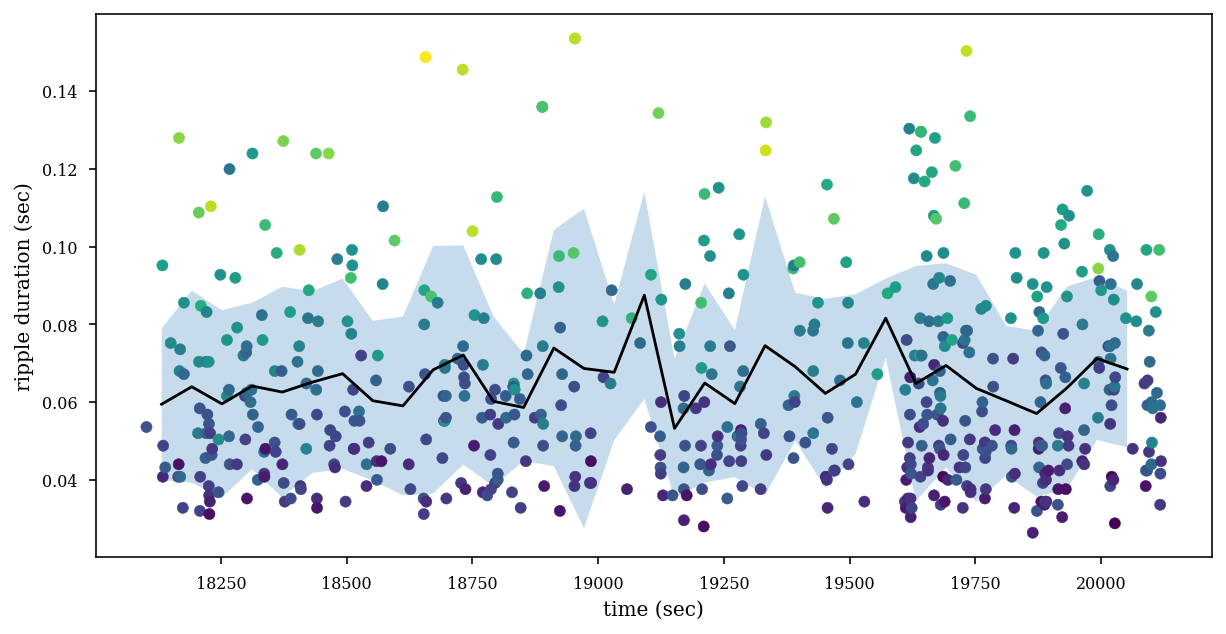

In [64]:
t = ripple_epochs[behavioral_epochs[1]].starts
dur = ripple_epochs[behavioral_epochs[1]].lengths

bin_width = 60
bins = np.arange(t.min(),t.max(),bin_width)
avg_dur = []
std_dur = []
for i in range(bins.shape[0]-1):
    idx = (t >= bins[i]) & (t<=bins[i+1])
    avg_dur.append(dur[idx].mean())
    std_dur.append(dur[idx].std())
avg_dur = np.array(avg_dur)
std_dur = np.array(std_dur)

plt.figure(figsize=(10,5))
plt.fill_between(bins[0:-1]+bin_width/2,avg_dur-std_dur,avg_dur+std_dur,alpha=.25)
plt.scatter(ripple_epochs[behavioral_epochs[1]].starts,ripple_epochs[behavioral_epochs[1]].lengths,c=pop_participation_prob)
plt.plot(bins[0:-1]+bin_width/2, avg_dur,color="k")

plt.xlabel('time (sec)')
plt.ylabel('ripple duration (sec)')

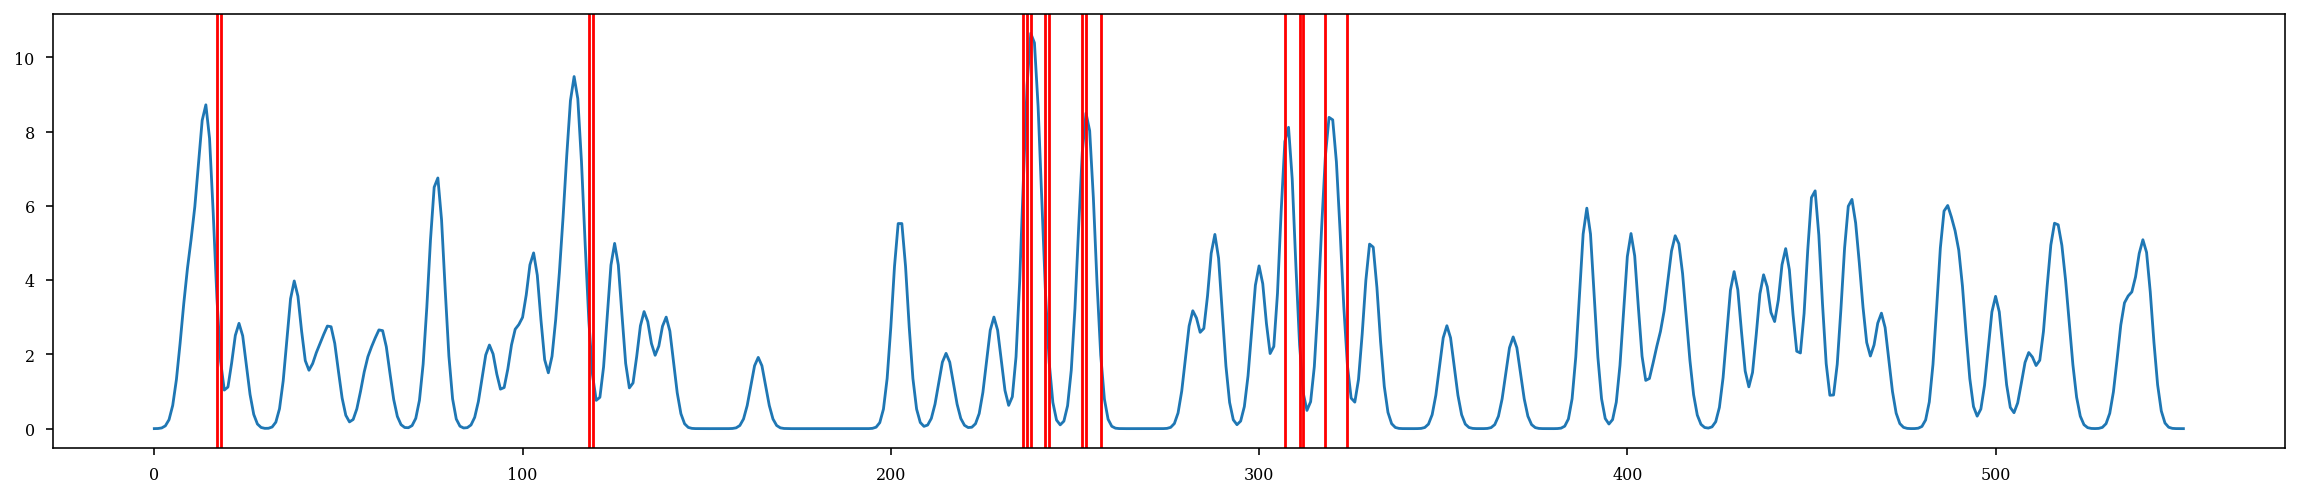

In [199]:
# temp_unit_mat = unit_mat.copy()
# temp_unit_mat[temp_unit_mat==0] = np.nan
# unit_mat_sm = gaussian_filter1d_nan(temp_unit_mat,sigma=2)

unit_mat_sm = gaussian_filter1d_nan(unit_mat,2)

a = np.array(unit_mat_sm[1,:])
b = a[1:] - a[:-1]  
v = abs(b) > 2
edges = v.nonzero()[0] 
edges += 2  
edges

plt.figure(figsize=(20,4))
plt.plot(a)
for e in edges:
    plt.axvline(e,color='r')

(array([  1,  17,  96, 106, 111, 137, 140, 141, 177, 178, 214, 249],
      dtype=int64),)


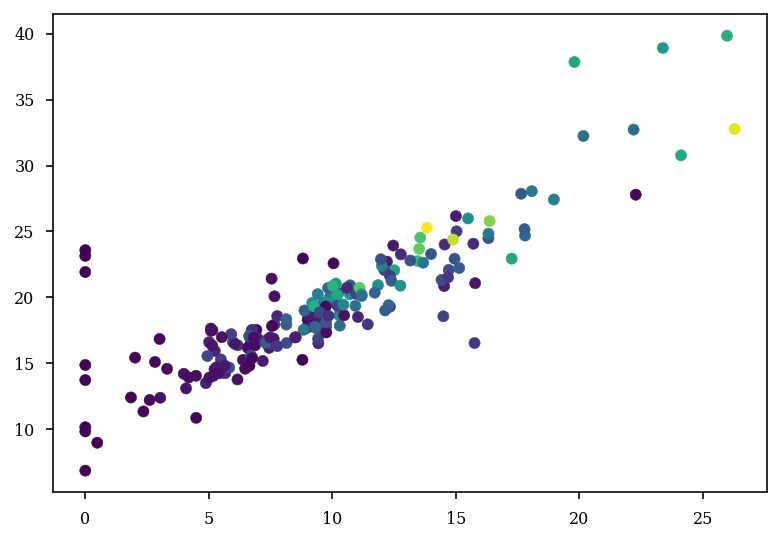

In [193]:
# np.std(unit_mat[unit_mat>0],axis=1)
# unit_mat>0
std_unit = [np.std(u[u>0]) for u in unit_mat]
mean_unit = [np.mean(u[u>0]) for u in unit_mat]

# plt.hist(std_unit,50)
# plt.show()

print(np.where(np.array(std_out)>20))

# print(cell_metrics.putativeCellType.iloc[np.array(std_unit)>20])

plt.scatter(std_unit,mean_unit,c=participation_prob)

In [159]:
def gaussian_filter1d_nan(X,sigma=1):
    X_out = X.copy()
    for i,x in enumerate(X_out):
        valid_idx = ~np.isnan(x)
        
        X_out[i,valid_idx] = gaussian_filter1d(x[valid_idx],sigma)
    return X_out

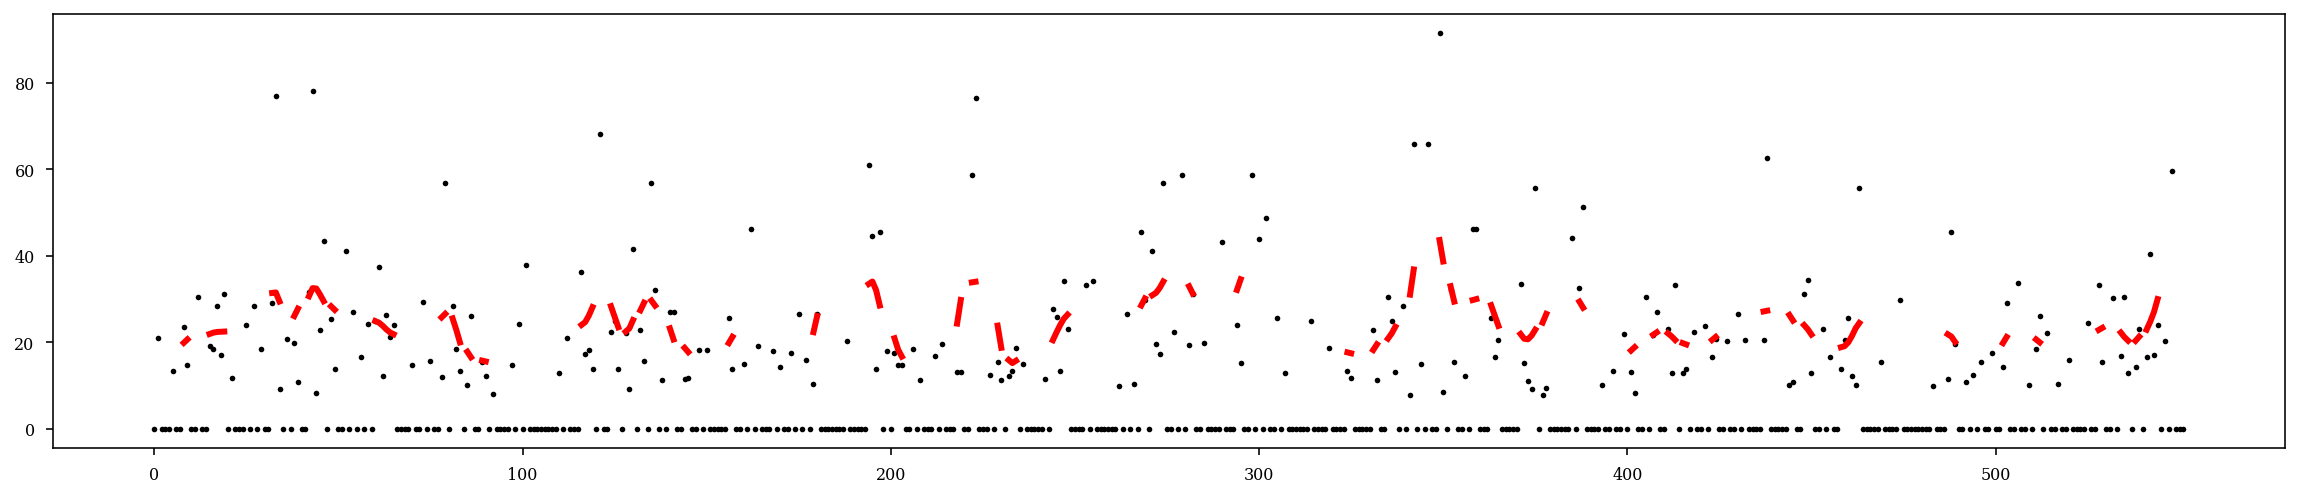

In [188]:
temp_unit_mat = unit_mat.copy()
temp_unit_mat[temp_unit_mat==0] = np.nan
unit_mat_sm = gaussian_filter1d_nan(temp_unit_mat,sigma=2)


plt.figure(figsize=(20,4))
plt.plot(unit_mat[124,:],'.k')
plt.plot(unit_mat_sm[124,:],color="r",linewidth=3)

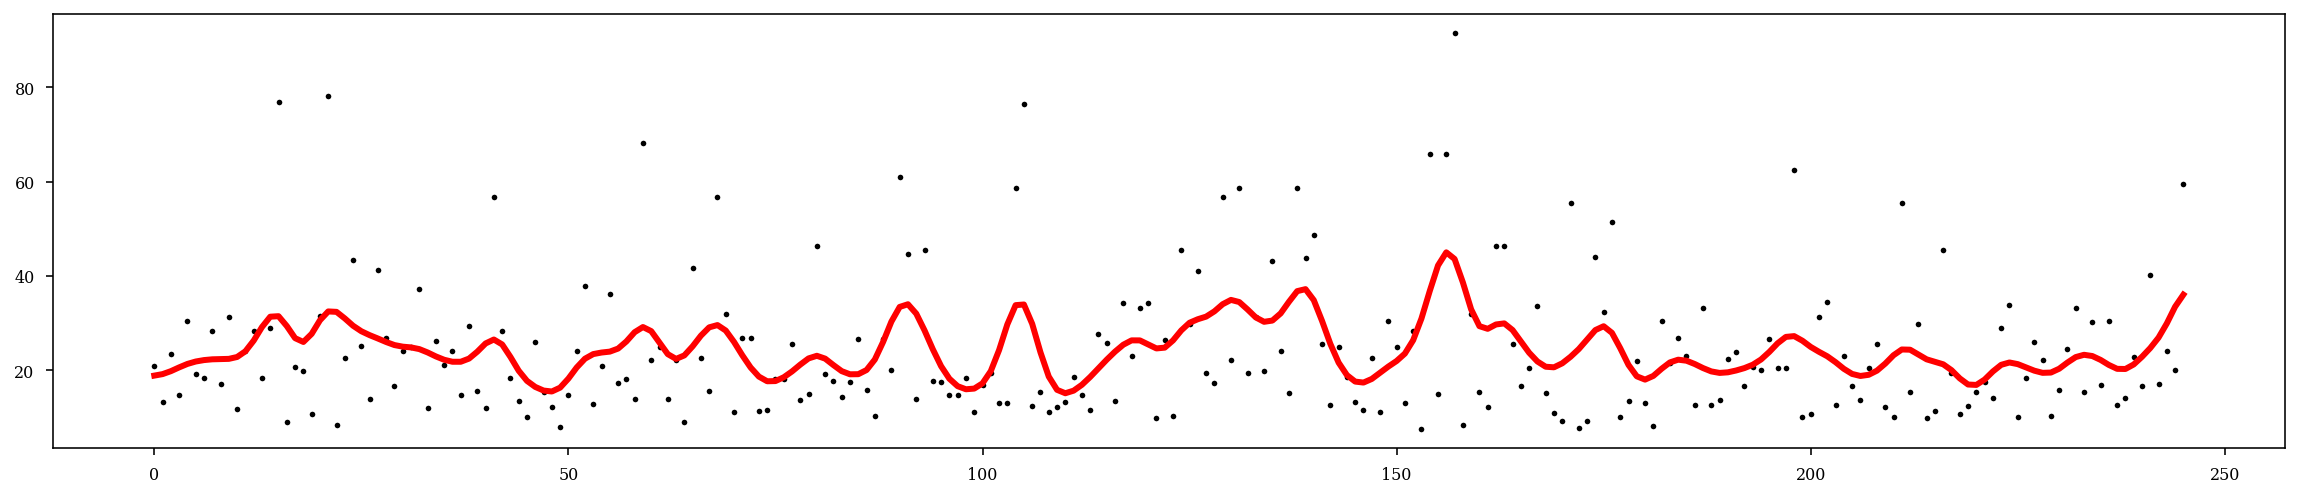

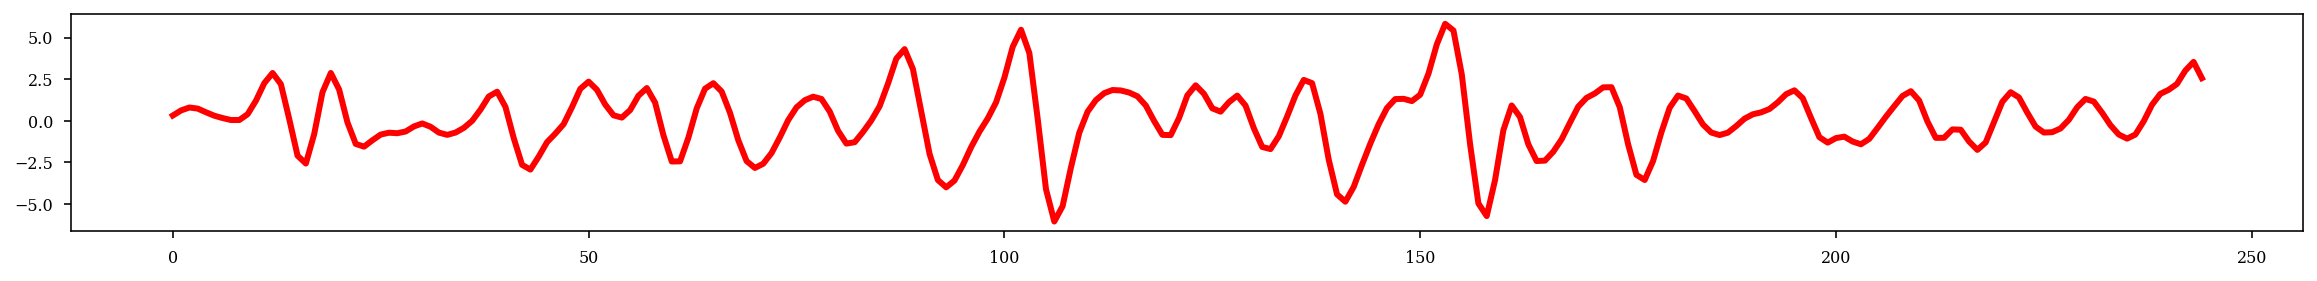

In [190]:
x = unit_mat[124,:]
x = x[x>0]
plt.figure(figsize=(20,4))
plt.plot(x,'.k')
plt.plot(gaussian_filter1d(x,2),color="r",linewidth=3)

plt.figure(figsize=(20,2))
plt.plot(np.diff(gaussian_filter1d(x,2)),color="r",linewidth=3)


<AxesSubplot:>

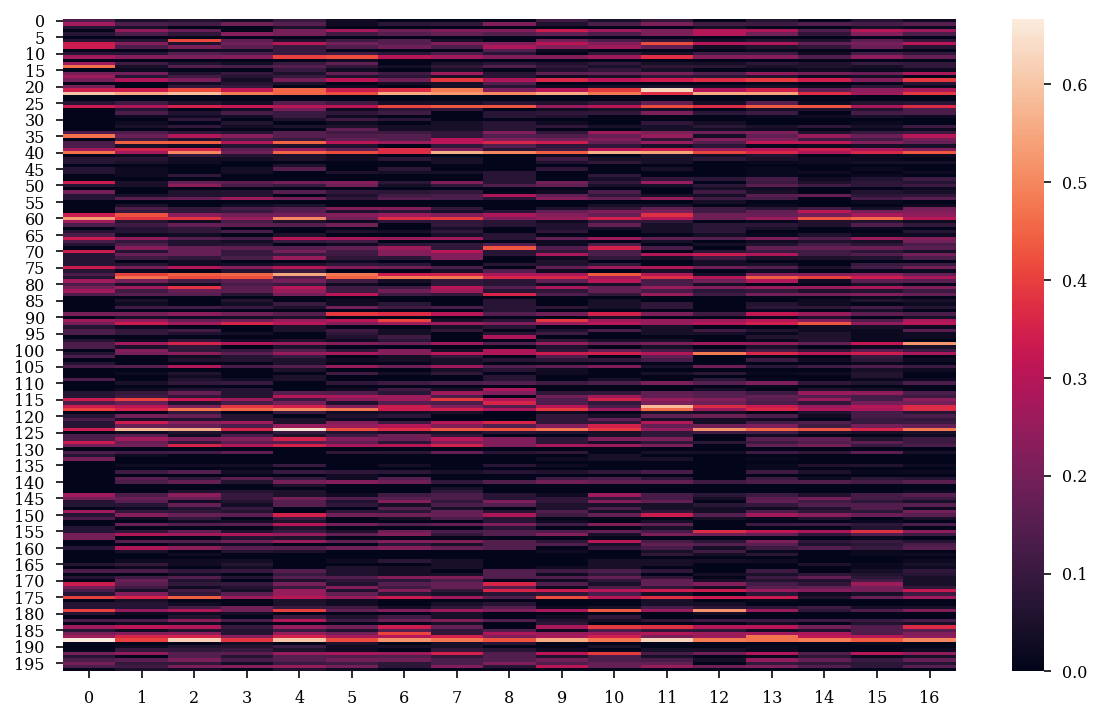

In [201]:
starts = ripple_epochs[behavioral_epochs[1]].starts
bins = np.arange(behavioral_epochs[1].start,behavioral_epochs[1].stop,120)

unit_mat_binary_rate= []
for i in range(len(bins)-1):
    idx = (starts>=bins[i]) & (starts<=bins[i+1]) 
    unit_mat_binary_rate.append(unit_mat_binary[:,idx].mean(axis=1))

unit_mat_binary_rate = np.vstack(unit_mat_binary_rate).T

plt.figure(figsize=(10,6))
sns.heatmap(unit_mat_binary_rate)

In [323]:
X = np.arange(0,unit_mat_binary_rate.shape[1])
# X = np.expand_dims(X, axis=1)
r2 = []
b = []
intercept = []
pval = []
std_err = []
for y in unit_mat_binary_rate:
    # reg = LinearRegression().fit(X, y)
    # r2.append(reg.score(X, y))
    # b.append(reg.coef_[0])
    # intercept.append(reg.intercept_)

    slope, intercept_, r_value, p_value, std_err_ = stats.linregress(X,y)
    b.append(slope)
    intercept.append(intercept_)
    r2.append(r_value)
    pval.append(p_value)
    std_err.append(std_err_)

b = np.array(b)
intercept = np.array(intercept)
r2 = np.array(r2)
pval = np.array(pval)
std_err = np.array(std_err)


In [290]:
unit_mat_binary_rate_df= pd.DataFrame(index = np.arange(unit_mat_binary_rate.shape[0]), columns = np.arange(unit_mat_binary_rate.shape[1]))
unit_mat_binary_rate_df[:] = unit_mat_binary_rate

Text(308.84607032008364, 0.5, 'n pyr cells')

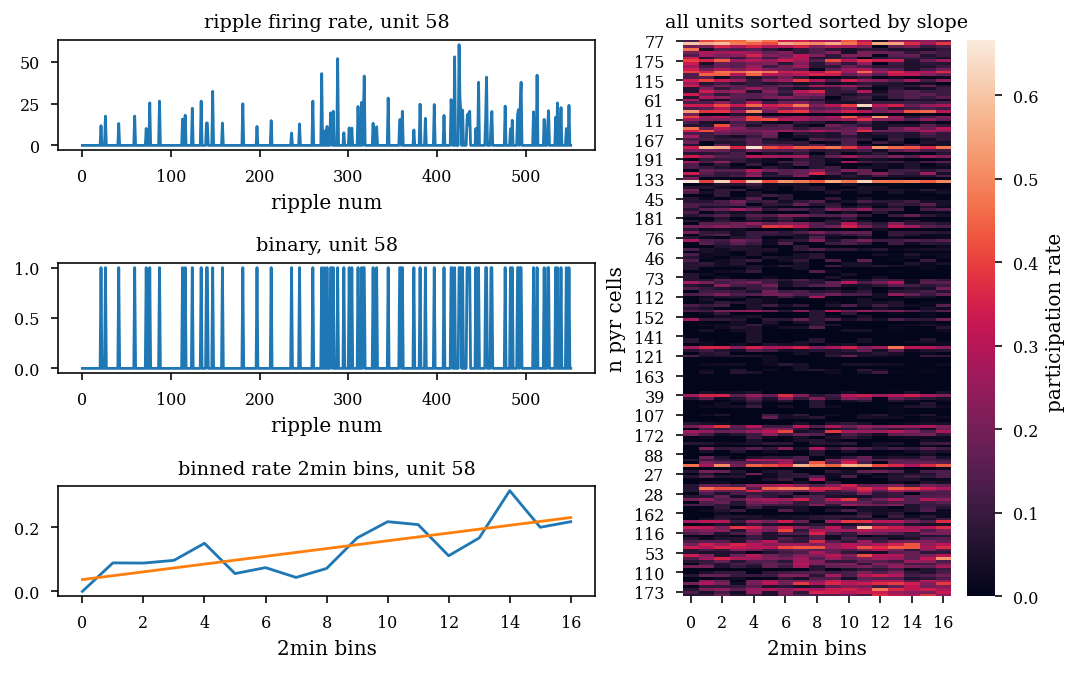

In [309]:
fig3 = plt.figure(figsize=functions.set_size('thesis', fraction=1.25, subplots=(3, 3)), edgecolor='k',constrained_layout=True)

unit_n = 58

gs = fig3.add_gridspec(3, 3)

f3_ax1 = fig3.add_subplot(gs[0, :-1])
f3_ax1.plot(unit_mat[unit_n])
f3_ax1.set_title('ripple firing rate, unit '+str(unit_n))

f3_ax2 = fig3.add_subplot(gs[1, :-1])
f3_ax2.plot(unit_mat_binary[unit_n])
f3_ax2.set_title('binary, unit '+str(unit_n))

f3_ax3 = fig3.add_subplot(gs[:, -1])
idx = np.argsort(b)
sns.heatmap(unit_mat_binary_rate_df.loc[idx],ax=f3_ax3,cbar_kws={'label': 'participation rate '})
f3_ax3.set_title('all units sorted sorted by slope')

f3_ax4 = fig3.add_subplot(gs[-1, :-1])
f3_ax4.plot(unit_mat_binary_rate[unit_n])

x = np.arange(0,unit_mat_binary_rate[unit_n].shape[0])
f3_ax4.plot(x,x*b[unit_n]+intercept[unit_n])
f3_ax4.set_title('binned rate 2min bins, unit '+str(unit_n))

f3_ax1.set_xlabel('ripple num')
f3_ax2.set_xlabel('ripple num')
f3_ax4.set_xlabel('2min bins')
f3_ax3.set_xlabel('2min bins')
f3_ax3.set_ylabel('n pyr cells')

# plt.savefig(os.path.join(fig_save_path,'participation_over_time_analysis_example.pdf'),dpi=300,bbox_inches='tight')


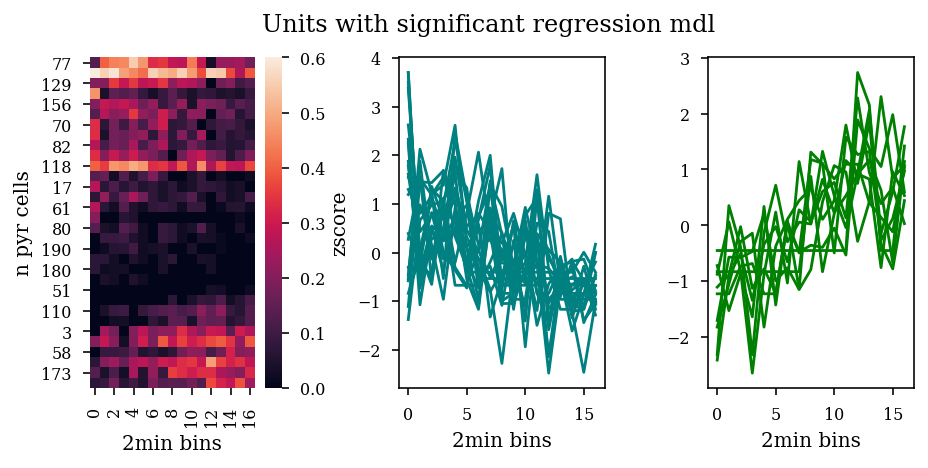

In [389]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1.25, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=.5)
axs = axs.ravel()

idx = np.argsort(b[pval<0.05])
sns.heatmap(unit_mat_binary_rate_df.loc[pval<0.05].iloc[idx],ax=axs[0])

axs[1].plot(stats.zscore(unit_mat_binary_rate_df.loc[(pval<0.05) & (b<0)],axis=1).T,color="teal")
axs[2].plot(stats.zscore(unit_mat_binary_rate_df.loc[(pval<0.05) & (b>0)],axis=1).T,color="green")

axs[0].set_xlabel('2min bins')
axs[0].set_ylabel('n pyr cells')

axs[1].set_xlabel('2min bins')
axs[2].set_xlabel('2min bins')

axs[1].set_ylabel('zscore')

fig.suptitle('Units with significant regression mdl', fontsize=12)
plt.savefig(os.path.join(fig_save_path,'participation_over_time_analysis_sig_examples.pdf'),dpi=300,bbox_inches='tight')



# relation between pre task participation probability and task participation change

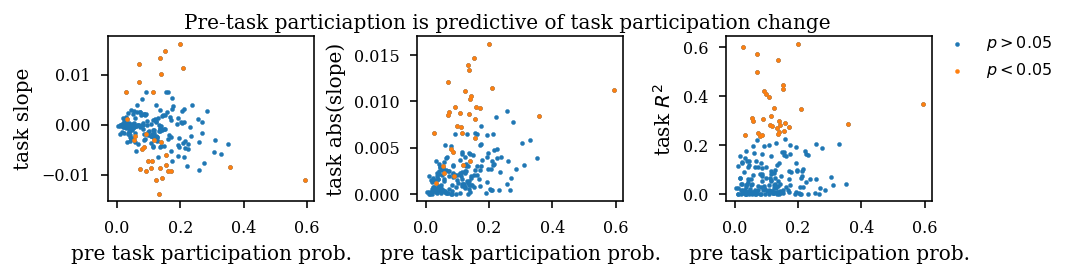

In [414]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=.5)
axs = axs.ravel()

axs[0].scatter(pre_participation_prob,b,s=4)
axs[0].scatter(pre_participation_prob[pval<0.05],b[pval<0.05],s=4)
axs[0].set_xlabel('pre task participation prob.')
axs[0].set_ylabel('task slope')

axs[1].scatter(pre_participation_prob,np.abs(b),s=4)
axs[1].scatter(pre_participation_prob[pval<0.05],np.abs(b[pval<0.05]),s=4)
axs[1].set_xlabel('pre task participation prob.')
axs[1].set_ylabel('task abs(slope)')

axs[2].scatter(pre_participation_prob,(r2**2),s=4,label="$p > 0.05$")
axs[2].scatter(pre_participation_prob[pval<0.05],(r2**2)[pval<0.05],s=4,label="$p < 0.05$")
# plt.yscale("log")
axs[2].set_xlabel('pre task participation prob.')
axs[2].set_ylabel('task $R^2$')

axs[2].legend(loc='best', bbox_to_anchor=(1.15, 0., 0.5, 1.1),frameon=False)

fig.suptitle('Pre-task particiaption is predictive of task participation change', fontsize=10)
plt.savefig(os.path.join(fig_save_path,'pre_to_task_participation_change.pdf'),dpi=300,bbox_inches='tight')


<AxesSubplot:>

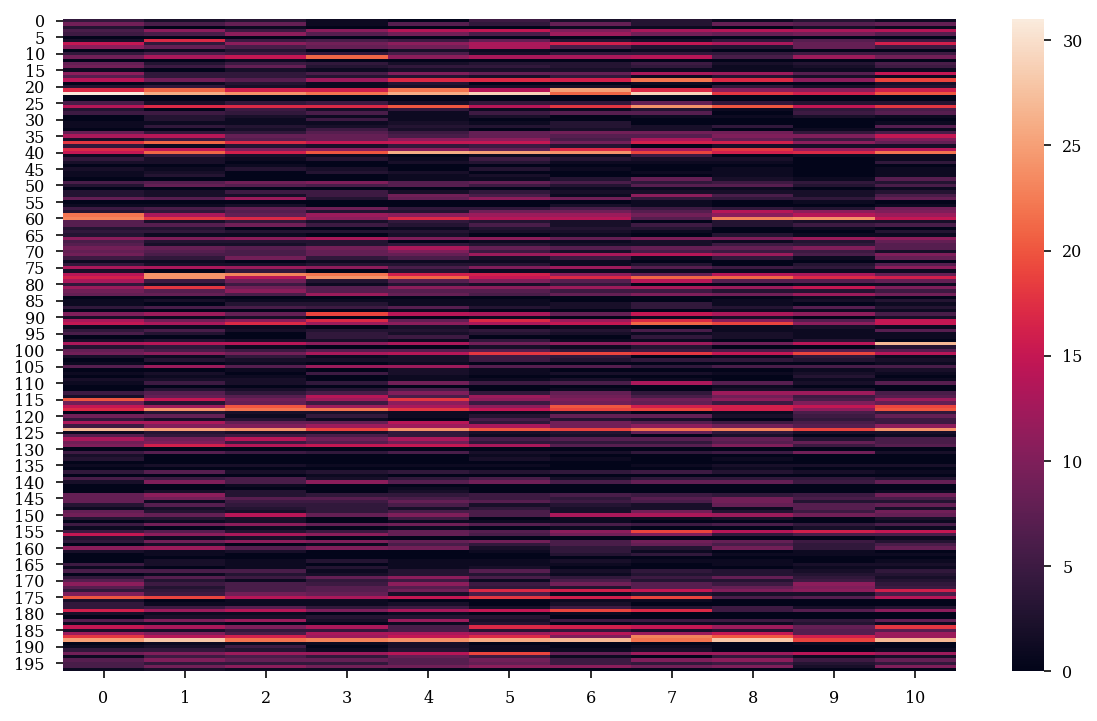

In [415]:
bins = np.arange(0,unit_mat_binary.shape[1],50)

unit_mat_binary_sum = []
for i in range(len(bins)-1):
    unit_mat_binary_sum.append(unit_mat_binary[:,bins[i]:bins[i+1]].sum(axis=1))

unit_mat_binary_sum = np.vstack(unit_mat_binary_sum).T

plt.figure(figsize=(10,6))
sns.heatmap(unit_mat_binary_sum)

In [420]:
# X = np.arange(0,unit_mat_binary_sum.shape[1])
# X = np.expand_dims(X, axis=1)
# r2 = []
# b = []
# intercept = []
# for y in unit_mat_binary_sum:
#     reg = LinearRegression().fit(X, y)
#     r2.append(reg.score(X, y))
#     b.append(reg.coef_[0])
#     intercept.append(reg.intercept_)


X = np.arange(0,unit_mat_binary_sum.shape[1])
r2 = []
b = []
intercept = []
pval = []
std_err = []
for y in unit_mat_binary_sum:
    slope, intercept_, r_value, p_value, std_err_ = stats.linregress(X,y)
    b.append(slope)
    intercept.append(intercept_)
    r2.append(r_value)
    pval.append(p_value)
    std_err.append(std_err_)

b = np.array(b)
intercept = np.array(intercept)
r2 = np.array(r2)
pval = np.array(pval)
std_err = np.array(std_err)

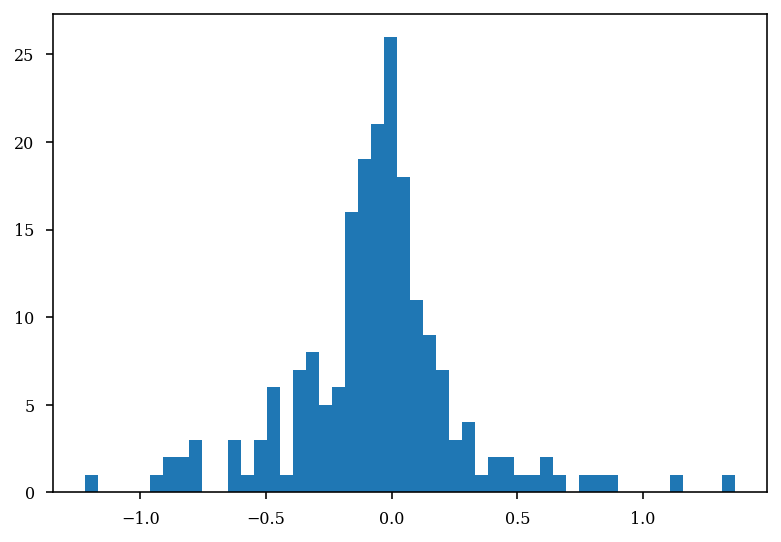

In [421]:
plt.hist(b,50)
plt.show()

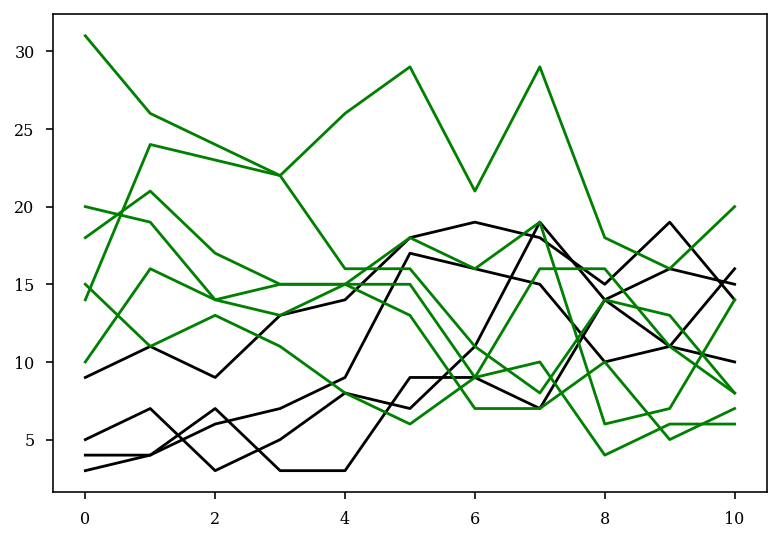

In [422]:
plt.plot(unit_mat_binary_sum[np.array(b)>0.8].T,color='k')
plt.plot(unit_mat_binary_sum[np.array(b)<-0.8].T,color='g')

plt.show()

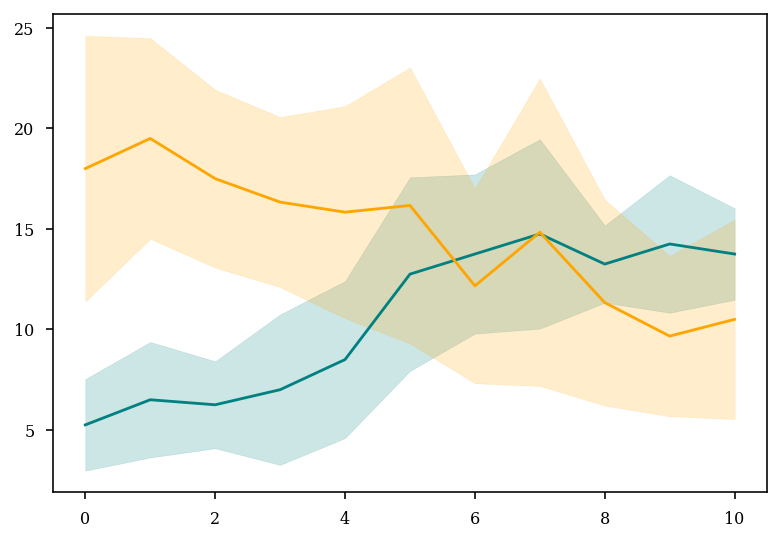

In [423]:
x = unit_mat_binary_sum[np.array(b)>0.8]
plt.plot(np.mean(x,axis=0),color="teal")
plt.fill_between(np.arange(0,len(np.mean(x,axis=0))),
                np.mean(x,axis=0)-np.std(x,axis=0),
                np.mean(x,axis=0)+np.std(x,axis=0),
                alpha=.2,zorder=-100,color="teal")

x = unit_mat_binary_sum[np.array(b)<-0.8]
plt.plot(np.mean(x,axis=0),color="orange")
plt.fill_between(np.arange(0,len(np.mean(x,axis=0))),
                np.mean(x,axis=0)-np.std(x,axis=0),
                np.mean(x,axis=0)+np.std(x,axis=0),
                alpha=.2,zorder=-100,color="orange")

<AxesSubplot:>

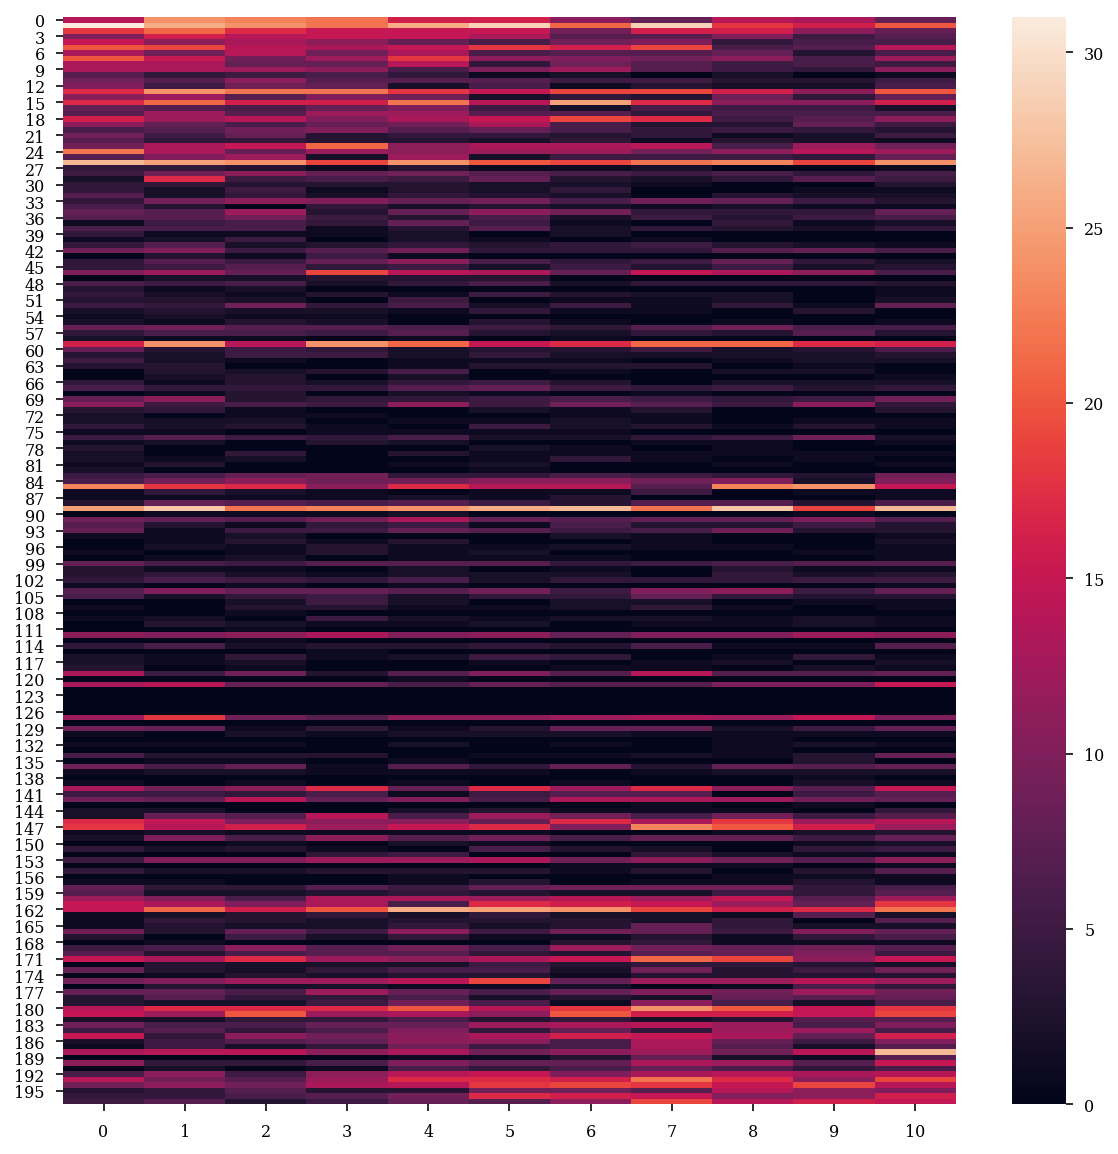

In [425]:
plt.figure(figsize=(10,10))
idx = np.argsort(b)
sns.heatmap(unit_mat_binary_sum[idx])

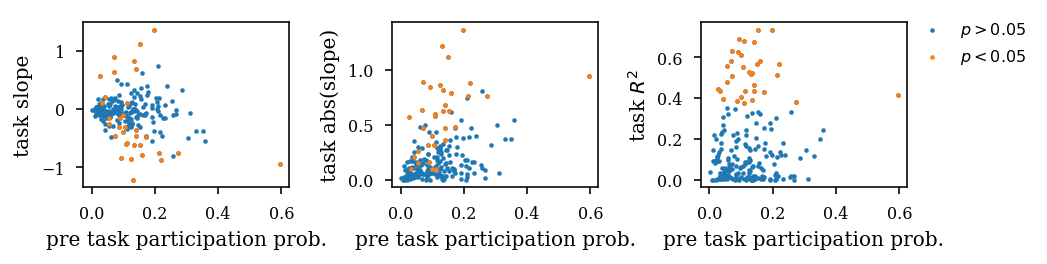

In [427]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=1.25, subplots=(1, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=.5)
axs = axs.ravel()

axs[0].scatter(pre_participation_prob,b,s=4)
axs[0].scatter(pre_participation_prob[pval<0.05],b[pval<0.05],s=4)
axs[0].set_xlabel('pre task participation prob.')
axs[0].set_ylabel('task slope')

axs[1].scatter(pre_participation_prob,np.abs(b),s=4)
axs[1].scatter(pre_participation_prob[pval<0.05],np.abs(b[pval<0.05]),s=4)
axs[1].set_xlabel('pre task participation prob.')
axs[1].set_ylabel('task abs(slope)')

axs[2].scatter(pre_participation_prob,(r2**2),s=4,label="$p > 0.05$")
axs[2].scatter(pre_participation_prob[pval<0.05],(r2**2)[pval<0.05],s=4,label="$p < 0.05$")
# plt.yscale("log")
axs[2].set_xlabel('pre task participation prob.')
axs[2].set_ylabel('task $R^2$')

axs[2].legend(loc='best', bbox_to_anchor=(1.15, 0., 0.5, 1.1),frameon=False)

In [132]:
df

Var1                                       basepath           basename
97     97  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  Achilles_10252013
98     98  Z:\Data\GrosmarkAD\Achilles\Achilles_11012013  Achilles_11012013
99     99        Z:\Data\GrosmarkAD\Buddy\Buddy_06272013     Buddy_06272013
100   100      Z:\Data\GrosmarkAD\Cicero\Cicero_09012014    Cicero_09012014
101   101      Z:\Data\GrosmarkAD\Cicero\Cicero_09102014    Cicero_09102014
102   102      Z:\Data\GrosmarkAD\Cicero\Cicero_09172014    Cicero_09172014
103   103      Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013    Gatsby_08022013
104   104      Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013    Gatsby_08282013

C:\Users\Cornell\AppData\Local\Temp/ipykernel_22736/1240438144.py:11: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_22736/1240438144.py:11: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_22736/1240438144.py:11: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_22736/1240438144.py:11: RuntimeWarning: Mean of empty slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of 

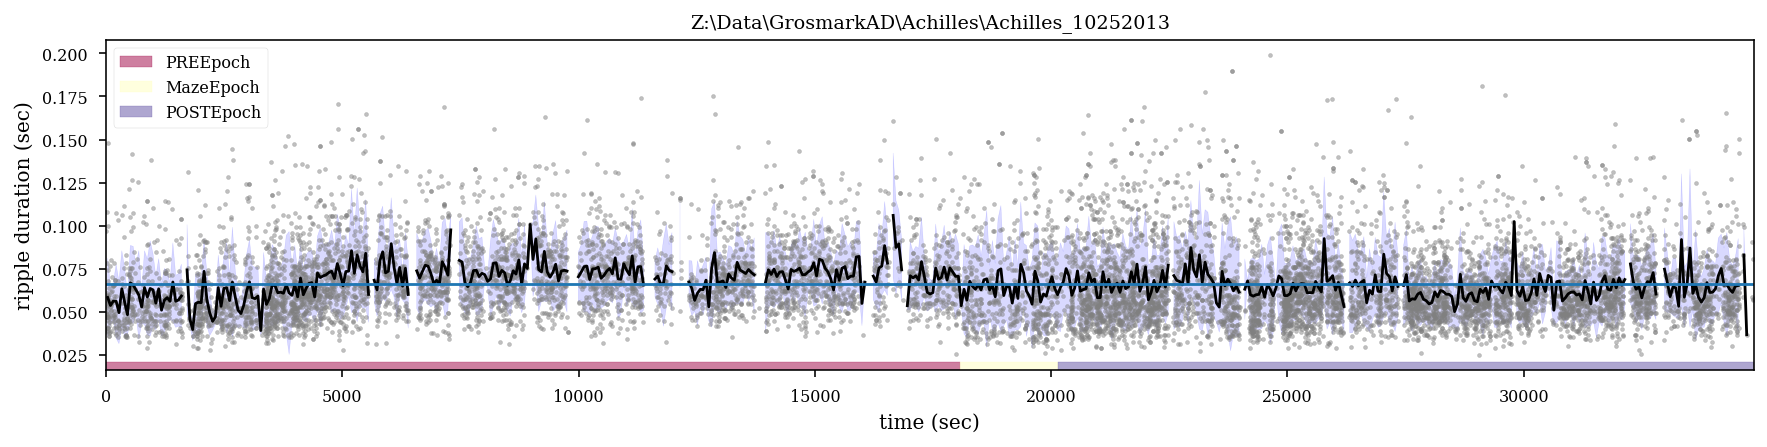

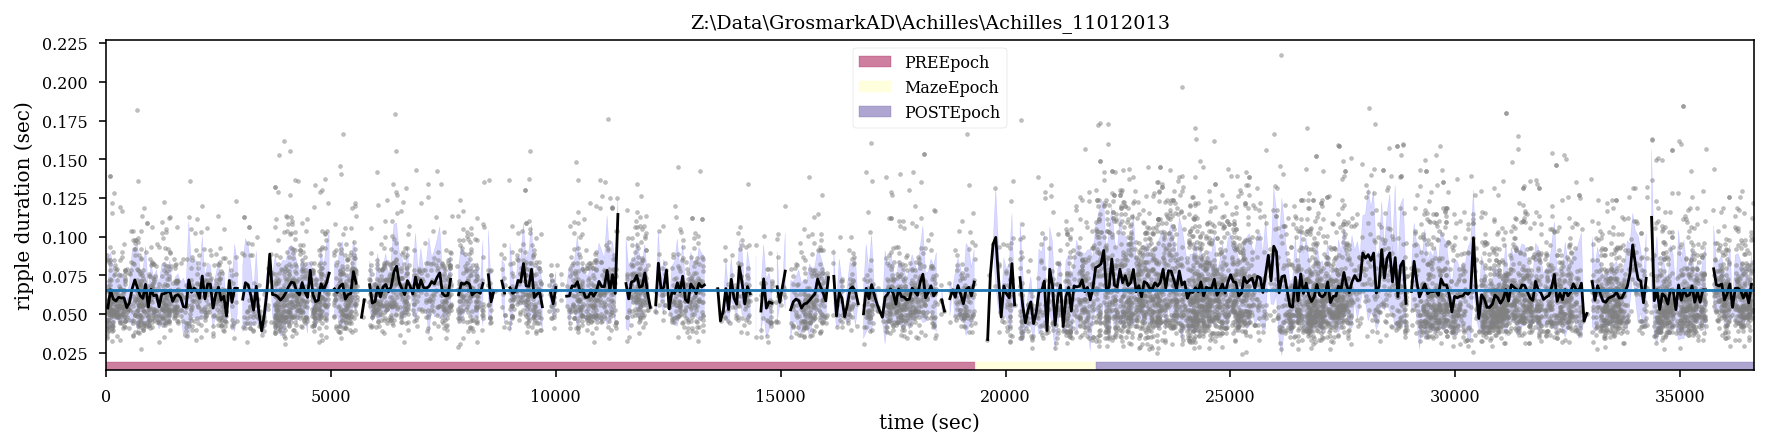

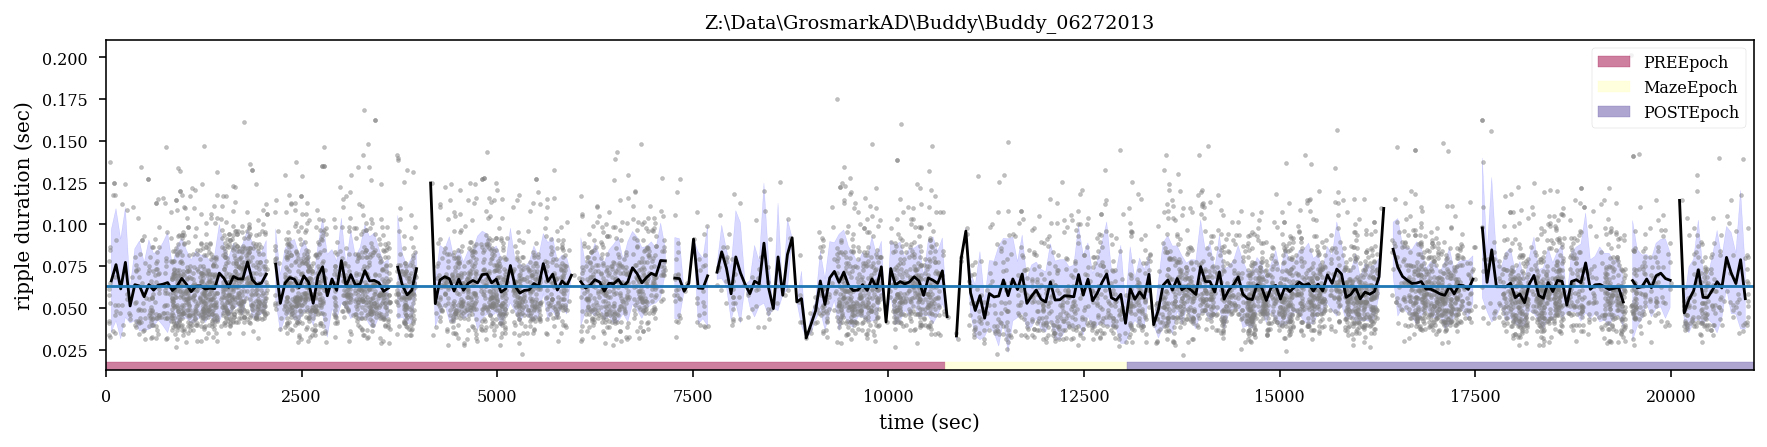

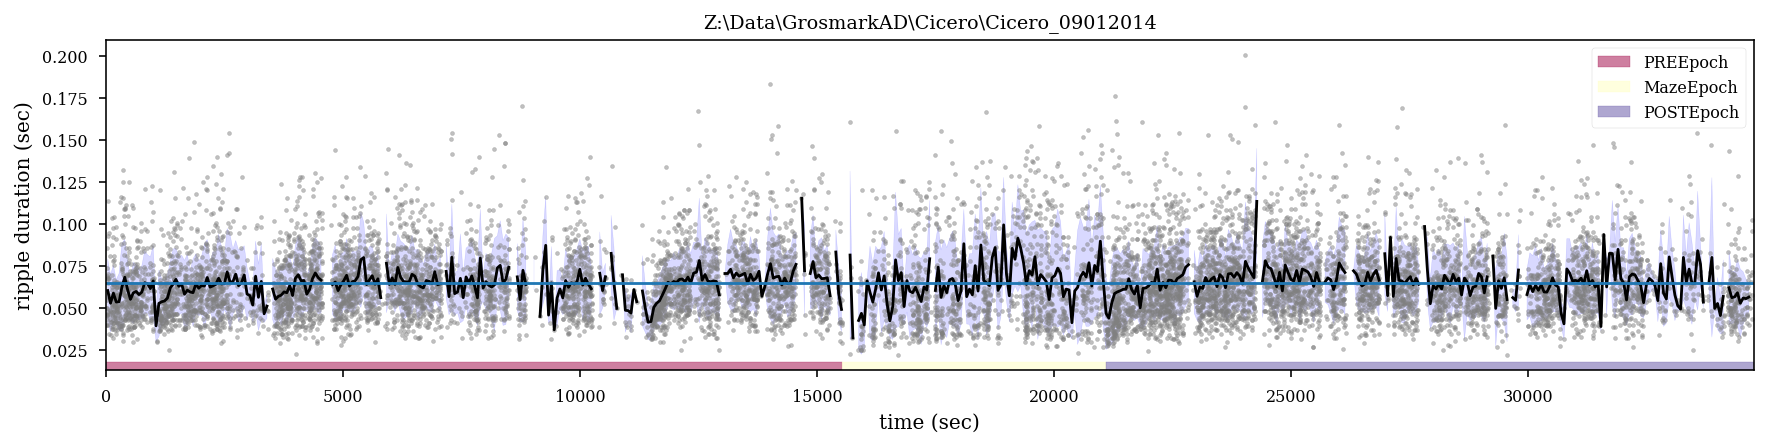

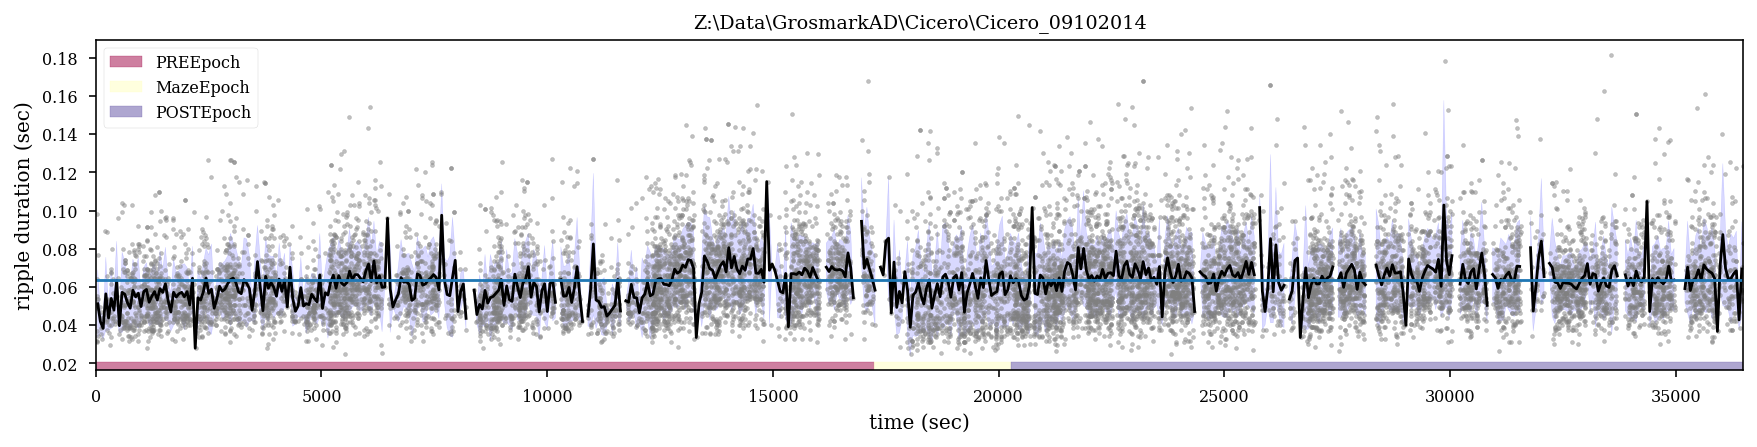

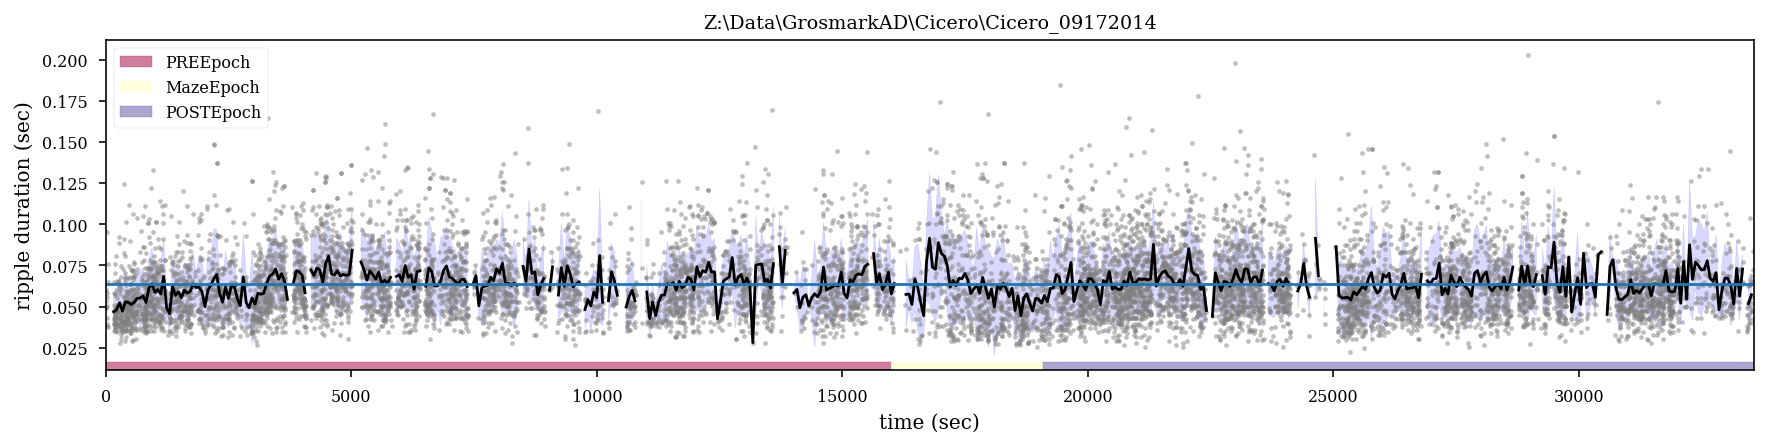

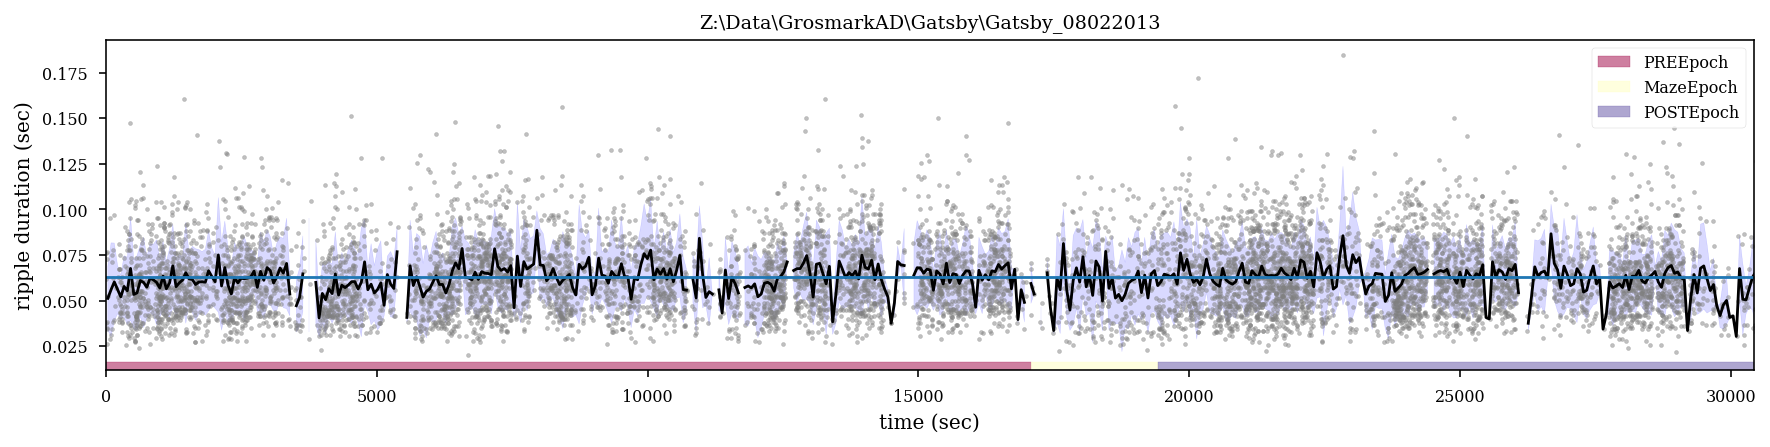

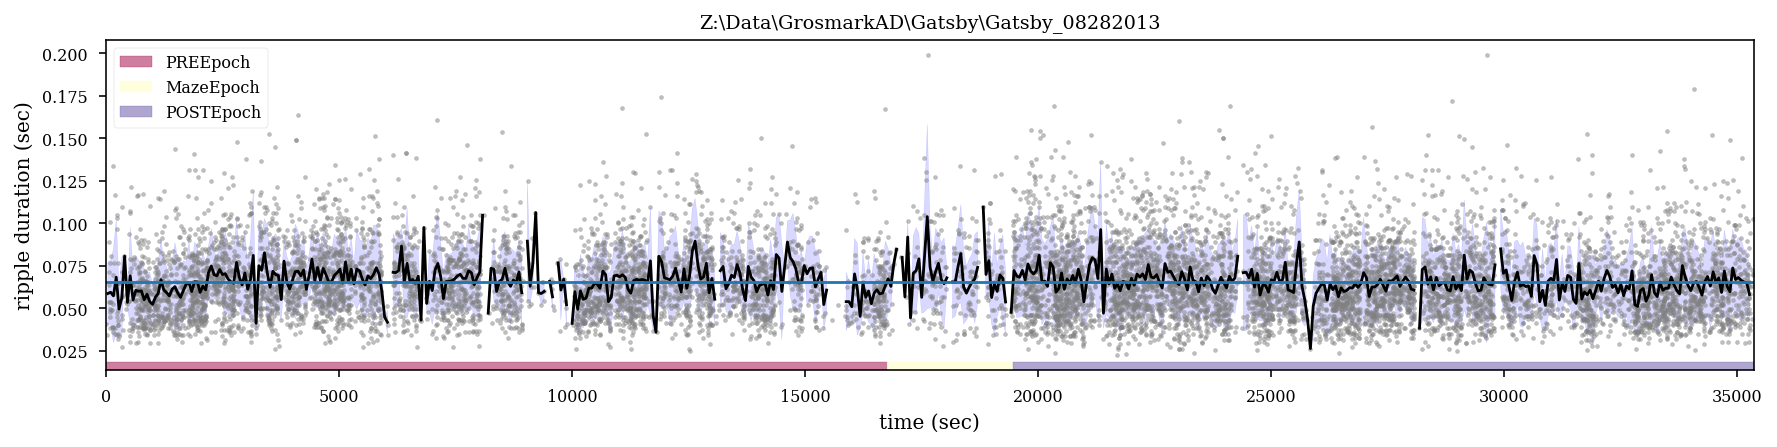

In [149]:
def plot_ripple_dur(behavioral_epochs,ripple_epochs,ax):
    t = ripple_epochs.starts
    dur = ripple_epochs.lengths

    bin_width = 60
    bins = np.arange(t.min(),t.max(),bin_width)
    avg_dur = []
    std_dur = []
    for i in range(bins.shape[0]-1):
        idx = (t >= bins[i]) & (t<=bins[i+1])
        avg_dur.append(np.nanmean(dur[idx]))
        std_dur.append(np.nanstd(dur[idx]))
    avg_dur = np.array(avg_dur)
    std_dur = np.array(std_dur)

    ax.fill_between(bins[0:-1]+bin_width/2,avg_dur-std_dur,avg_dur+std_dur,alpha=.15,color="blue")
    ax.scatter(ripple_epochs.starts,ripple_epochs.lengths,alpha=.5,s=4,color="grey")
    ax.plot(bins[0:-1]+bin_width/2, avg_dur,color="k")

    cmap = matplotlib.cm.get_cmap('Spectral',behavioral_epochs.starts.shape[0])

    for i in range(behavioral_epochs.starts.shape[0]):
        ax.axvspan(behavioral_epochs.starts[i],behavioral_epochs.stops[i],0,.025,color=cmap(i),alpha=.5,label=data['epochs'].name.iloc[i])

    ax.legend()
    ax.axhline(ripple_epochs.lengths.mean())

    ax.set_xlim(0,behavioral_epochs.stop)

    ax.set_xlabel('time (sec)')
    ax.set_ylabel('ripple duration (sec)')


for i,basepath in enumerate(df.basepath):
    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)
    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

    # behavioral epochs
    behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                        data['epochs'].stopTime]).T])

    plt.figure(figsize=functions.set_size('thesis', fraction=2.5, subplots=(1, 3)), edgecolor='k')
    ax = plt.gca()
    plot_ripple_dur(behavioral_epochs,ripple_epochs,ax)
    ax.set_title(basepath)

    plt.savefig(os.path.join(fig_save_path,os.path.basename(basepath)+'ripple_duration_over_time.pdf'),dpi=300,bbox_inches='tight')